# Pathway analysis of metagenomic data

First, install the libraries and import them


In [23]:
# check if libraries are already installed > otherwise install it
if(!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager",repos = "http://cran.us.r-project.org")
if(!"clusterProfiler" %in% installed.packages()) BiocManager::install("clusterProfiler")
if(!"KEGGREST" %in% installed.packages()) BiocManager::install("KEGGREST")
if(!"org.EcK12.eg.db" %in% installed.packages()) BiocManager::install("org.EcK12.eg.db")
if(!"limma" %in% installed.packages()) BiocManager::install("limma")
if(!"DESeq2" %in% installed.packages()) BiocManager::install("DESeq2")
if(!"edgeR" %in% installed.packages()) BiocManager::install("edgeR")
if(!"ggplot2" %in% installed.packages()) BiocManager::install("ggplot2")

#load packages
library(clusterProfiler)
library(KEGGREST)
library(org.EcK12.eg.db)
library(limma)
library(DESeq2)
library(edgeR)
library(ggplot2)

In [2]:
# Import the metagenomics data
metagenomics <- read.csv(file = '../Data/ecs_relab_split.csv', sep = '\t', header = TRUE)
head(metagenomics)

,Gene.Family,Name.Organism,CSM5FZ4M,CSM5MCUO,CSM5MCVL,CSM5MCVN,CSM5MCW6,CSM5MCWC,CSM5MCWE,CSM5MCWG,...,CSM5MCVJ_P,CSM5MCWI_P,MSM5LLHA_P,HSM5MD59_P,HSM5MD8N_P,CSM6J2H9_P,HSM5MD4A_P,CSM5MCUW_P,ESM5MEBA_P,HSM5FZC2_P
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.1.1.100,3-oxoacyl-[acyl-carrier-protein] reductase,0.00183508,0.00147242,0.00157135,0.00117332,0.000246863,0.00238904,0.000922349,0.000573488,...,0.00172861,0.00180843,0.000636998,0.00190471,0.00168832,0.00183791,0.00191878,0.00139149,0.00124719,0.000429274
2,1.1.1.100,3-oxoacyl-[acyl-carrier-protein] reductase|g__Aggregatibacter.s__Aggregatibacter_segnis,0,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.000000000,...,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000
3,1.1.1.100,3-oxoacyl-[acyl-carrier-protein] reductase|g__Alloprevotella.s__Alloprevotella_tannerae,0,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.000000000,...,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000
4,1.1.1.100,3-oxoacyl-[acyl-carrier-protein] reductase|g__Anaerococcus.s__Anaerococcus_obesiensis,0,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.000000000,...,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000
5,1.1.1.100,3-oxoacyl-[acyl-carrier-protein] reductase|g__Anaerococcus.s__Anaerococcus_vaginalis,0,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.000000000,...,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000
6,1.1.1.100,3-oxoacyl-[acyl-carrier-protein] reductase|g__Anaerofustis.s__Anaerofustis_stercorihominis,0,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.000000000,0.000000000,...,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000


# Differential gene expression analysis

In [4]:
# Import metadata file
metadata <- read.csv(file = '../Data/hmp2_metadata_2018-08-20.csv', sep = ',', header = TRUE)
# Select metagenomics
metagenomics_metadata <- metadata[metadata$data_type=='metagenomics',]
# Write metagenomics metadata file into csv
write.csv(metagenomics_metadata,"..\\Data\\Metagenomics_metadata.csv", row.names = FALSE)

In [15]:
metagenomics_metadata <- read.csv(file = '../Data/Metagenomics_metadata.csv', sep = ',', header = TRUE)
metagenomics_metadata_subset <- subset(metagenomics_metadata, select= c(External.ID, diagnosis, visit_num))
metagenomics_metadata_subset <- metagenomics_metadata_subset[metagenomics_metadata_subset$visit_num==4,]

In [4]:
# Separate CD, UC and nonIBD
cd <- metagenomics_metadata_subset[metagenomics_metadata_subset$diagnosis=="CD",]
uc <- metagenomics_metadata_subset[metagenomics_metadata_subset$diagnosis=="UC",]
nonIBD <- metagenomics_metadata_subset[metagenomics_metadata_subset$diagnosis=="nonIBD",]

In [5]:
# select metagenomics data from CD, UC and nonIBD
metagenomics_cd <- subset(metagenomics, select= c("Gene.Family", cd$External.ID))
metagenomics_uc <- subset(metagenomics, select= c("Gene.Family", uc$External.ID))
metagenomics_nonIBD <- subset(metagenomics, select= c("Gene.Family", nonIBD$External.ID))

In [12]:
mgxCount <- as.matrix(subset(metagenomics, select=-2))
head(mgxCount)

,Gene.Family,CSM5FZ4M,CSM5MCUO,CSM5MCVL,CSM5MCVN,CSM5MCW6,CSM5MCWC,CSM5MCWE,CSM5MCWG,CSM5MCWQ,...,CSM5MCVJ_P,CSM5MCWI_P,MSM5LLHA_P,HSM5MD59_P,HSM5MD8N_P,CSM6J2H9_P,HSM5MD4A_P,CSM5MCUW_P,ESM5MEBA_P,HSM5FZC2_P
1,1.1.1.100,0.00183508,1.47242e-03,1.57135e-03,1.17332e-03,2.46863e-04,2.38904e-03,9.22349e-04,5.73488e-04,1.82744e-03,...,1.72861e-03,1.80843e-03,6.36998e-04,1.90471e-03,1.68832e-03,1.83791e-03,1.91878e-03,1.39149e-03,1.24719e-03,4.29274e-04
2,1.1.1.100,0,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,...,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
3,1.1.1.100,0,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,...,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
4,1.1.1.100,0,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,...,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
5,1.1.1.100,0,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,...,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00
6,1.1.1.100,0,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,...,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00,0.00000e+00


In [21]:
head(sampleLabels)

,External.ID,diagnosis,group
,<chr>,<fct>,<fct>
1,CSM5FZ3N_P,CD,CD
17,CSM5FZ3T_P,CD,CD
42,CSM5FZ4A_P,UC,UC
78,CSM5MCTZ_P,UC,UC
89,CSM5MCVB_P,CD,CD
92,CSM5MCU4_P,CD,CD


In [20]:
#read  the input data file
htxCount <- apply(as.matrix(subset(metagenomics, select=-c(1, 2))), 2, as.numeric)

#checking which samples have all zero values across all genes
#these sample should be removed otherwise there will be a problem when calculating estimate size factors
idx <- which(colSums(htxCount) == 0)
#CSMDRVXI MSM719ME  are samples who has all zero values so we remove them
htxCount <- htxCount[ , -idx]

#read metadata file sample labels
sampleLabels <- subset(metagenomics_metadata_subset, select= c(External.ID, diagnosis))
#apply same filtering to the metadata remove samples from sample labels metadata
#sampleLabels <- sampleLabels[-idx , ]

#add column names to the metadata file
#colnames(sampleLabels) <- c( "sampleID", "biopsy_location","disease")
#check whether sample names are in same order
#all(colnames(htxCount) == rownames(sampleLabels))

#select only biopsy_location and disease columns
#sampleLabels<-sampleLabels[, c(2,3)]
sampleLabels$diagnosis <- relevel(as.factor(sampleLabels$diagnosis),ref="nonIBD")
#add an experimental group variable to sampleLabels
sampleLabels$group <- as.factor(sampleLabels$diagnosis)


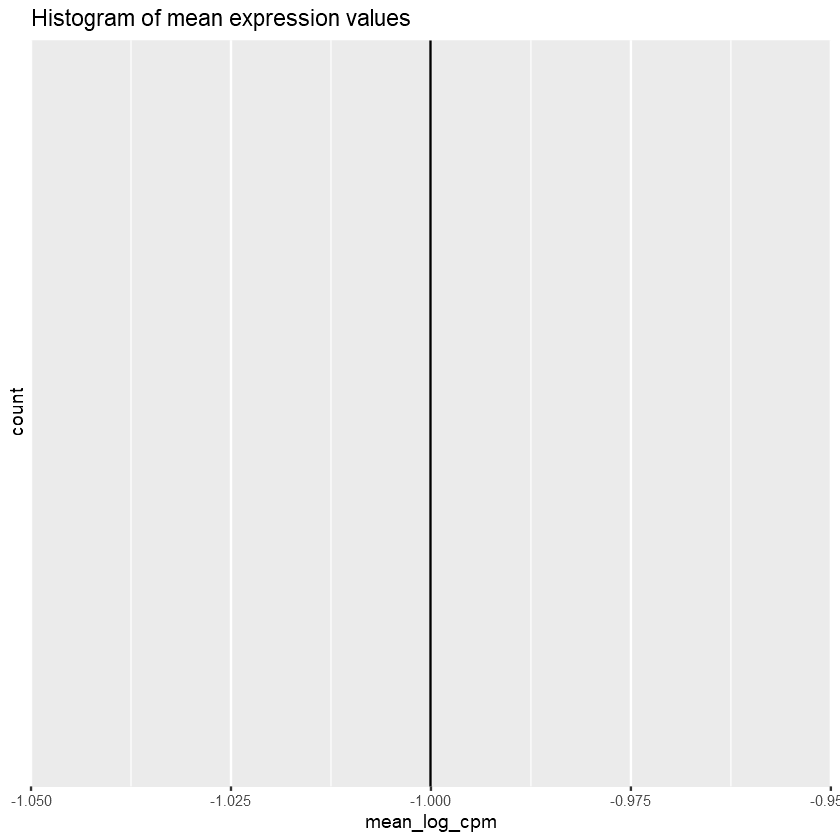

In [24]:
#remove genes which has all zero values for all samples then start DE analysis
nonzero <- rowSums(htxCount) > 0
htxCount %<>% .[nonzero,]

#############################CPM FILTERING#############################################
#aveLogCPM function compute average log2 counts-per-million for each row of counts.
#the below function is similar to log2(rowMeans(cpm(y, ...)))
mean_log_cpm = aveLogCPM(htxCount)

# We plot the distribution of average log2 CPM values to verify that our chosen presence threshold is appropriate. The distribution is expected to be bimodal, with a low-abundance peak representing non-expressed genes and a high-abundance peak representing expressed genes. The chosen threshold should separate the two peaks of the bimodal distribution. 
filter_threshold <- -1# we can try different threshold values
#jpeg(file="avgLogCpmDist.jpeg")#if you want to save the histogram uncomment the following command  
ggplot() + aes(x=mean_log_cpm) +
    geom_histogram(binwidth=0.2) +
    geom_vline(xintercept=filter_threshold) +
    ggtitle("Histogram of mean expression values")
#dev.off()#to save the plot to the file
#Having chosen our threshold, lets pick the subset of genes whose average expression passes that threshold.
keep_genes <- mean_log_cpm >= filter_threshold 
htxCount <- htxCount[keep_genes,]
#dim(htxCount)#to check dimension of the data
###############################################################################


In [34]:
sampleLabels <- apply(as.matrix(sampleLabels), 2, as.factor)
head(sampleLabels)

,External.ID,diagnosis,group
1,CSM5FZ3N_P,CD,CD
17,CSM5FZ3T_P,CD,CD
42,CSM5FZ4A_P,UC,UC
78,CSM5MCTZ_P,UC,UC
89,CSM5MCVB_P,CD,CD
92,CSM5MCU4_P,CD,CD


In [35]:
#we wil firstly create a DESeqDataSet object
#(non-intercept) statistical model based on the disease and biopsy_location, group column represent both of them 
dds <- DESeqDataSetFromMatrix(countData = htxCount, colData=sampleLabels, design= ~0 + group)
dds <- estimateSizeFactors(dds)

#run differential analysis
dds <- DESeq(dds)

cont.matrix <- makeContrasts(
  #CD disease on ileum and rectum 
  CD_vs_nonIBD   = groupCD - groupnonIBD,
  UC_vs_nonIBD   = groupUC - groupnonIBD,
  levels = resultsNames(dds)
)

#extract resulting contrasts based on the model, and save those in a table; also save some graphical representations
#the function results() is called from within the saveStatOutputDESeq2 function to compute the contrasts
files <- saveStatOutputDESeq2(cont.matrix,dds,postfix="",annotation=NULL)
#create summary table of the contrast results
#up and down for p-val and adj p-val are decided by for example log2fc>=0.58 and  log2fc<0.58
createPvalTab(files,postfix="",namePVal="pvalue",nameAdjPVal="padj",nameFC="FoldChange",nameLogFC="log2FoldChange",html=TRUE)

ERROR: Error in DESeqDataSetFromMatrix(countData = htxCount, colData = sampleLabels, : ncol(countData) == nrow(colData) is not TRUE


In [ ]:
##Calculate p-value for two groups based on t-test (comparing control to disease).
##general function to store p-values for multiple rows:
ttest_mSet <- function(df, grp1, grp2) {
  x = df[grp1]
  y = df[grp2]
  x = as.numeric(x)
  y = as.numeric(y)  
  results = t.test(x, y)
  results$p.value
}
p_values_disorder <- apply(mSet_FINAL, 1, ttest_mSet, grp1 = c(3:end_Disorders), grp2 = c((end_Disorders+1):ncol(mSet_FINAL)))
##Add p_values column to analysis dataset:
mSet_AnalysisReady <- cbind(mSet_AnalysisReady, p_values_disorder)
#Convert logFC and p-values columns to numeric values            
mSet_AnalysisReady <- as.data.frame(mSet_AnalysisReady)
mSet_AnalysisReady[ , c(3,4)] <- apply(mSet_AnalysisReady[ , c(3,4)], 2, function(x) as.numeric(as.character(x)))
remove(mSet_transformed, columns_disorders, columnNumber, end_Disorders, foldchange_disorder, p_values_disorder, control_IBD, disease, ttest_mSet, mSet_FINAL


In [9]:
# Compute statistical significance (using t-test)
pvalue_cd = NULL # Empty list for the p-values
tstat_cd = NULL # Empty list of the t test statistics

for(i in 1 : nrow(metagenomics_Ecoli)) { # For each gene : 
	x = metagenomics_nonIBD[i,-1] # control of gene number i
	y = metagenomics_cd[i,-1] # CD of gene number i
	
	# Compute t-test between the two conditions
	t = t.test(x, y)
	
	# Put the current p-value in the pvalues list
	pvalue_cd[i] = t$p.value
	# Put the current t-statistic in the tstats list
	tstat_cd[i] = t$statistic
}

In [10]:
# Compute statistical significance (using t-test)
subset_NA = NULL

for(i in 1 : nrow(metagenomics_Ecoli)) { # For each gene : 

	x = metagenomics_nonIBD[i,-1] # Control of gene number i
	y = metagenomics_uc[i,-1] # UC of gene number i

	metagenomics_nonIBD_NA = all(is.na(x)) || length(is.na(x)==FALSE)<2
	metagenomics_uc_NA = all(is.na(y)) || length(is.na(y)==FALSE)<2
	subset_NA[i] = metagenomics_nonIBD_NA || metagenomics_uc_NA
	
}
metagenomics_uc_nonNA <- metagenomics_uc[!subset_NA,]
metagenomics_nonIBD_nonNA <- metagenomics_nonIBD[!subset_NA,]

In [11]:
# Compute statistical significance (using t-test)
pvalue_uc = NULL # Empty list for the p-values
tstat_uc = NULL # Empty list of the t test statistics

for(i in 1 : nrow(metagenomics_nonIBD_nonNA)) { # For each gene : 
	x = metagenomics_nonIBD_nonNA[i,-1] # control of gene number i
	y = metagenomics_uc_nonNA[i,-1] # UC of gene number i	
	
	# Compute t-test between the two conditions
	t = t.test(x, y)
	
	# Put the current p-value in the pvalues list
	pvalue_uc[i] = t$p.value
	# Put the current t-statistic in the tstats list
	tstat_uc[i] = t$statistic
}

https://ucdavis-bioinformatics-training.github.io/2018-June-RNA-Seq-Workshop/thursday/DE.html

In [ ]:
mgxCount <- as.matrix(subset(metagenomics, select=-2))
d0 <- DGEList(mgxCount)
d0 <- calcNormFactors(d0)

cutoff <- 1
drop <- which(apply(cpm(d0), 1, max) < cutoff)
d <- d0[-drop,] 

snames <- colnames(counts) # Sample names
mm <- model.matrix(~0 + group)
fit <- lmFit(y, mm)
head(coef(fit))
contr <- makeContrasts(groupUC - groupNonIBD, levels = colnames(coef(fit)))
tmp <- contrasts.fit(fit, contr)
tmp <- eBayes(tmp)
top.table <- topTable(tmp, sort.by = "P", n = Inf)
head(top.table, 20)

length(which(top.table$adj.P.Val < 0.05))

In [12]:
metagenomics_Ecoli$pvalue_cd <- pvalue_cd
metagenomics_Ecoli$pvalue_uc <- pvalue_uc
cd_genes <- subset(metagenomics_Ecoli[metagenomics_Ecoli$pvalue_cd<=0.05,], select="Gene.Family", "")
uc_genes <- subset(metagenomics_Ecoli[metagenomics_Ecoli$pvalue_uc<=0.05,], select="Gene.Family")

In [42]:
#metagenomics_Ecoli[order(metagenomics_Ecoli$pvalue_cd)]
dim(metagenomics_Ecoli)

[1]  927 1642

In [58]:
#list of all deg from two disease types 
deg.CD <- subset(metagenomics_Ecoli[!is.na(metagenomics_Ecoli$pvalue_cd) & metagenomics_Ecoli$pvalue_cd < 0.1,c(1,2)])
#CD.up   <-unique(dataset.CD[!is.na(metagenomics_Ecoli$pvalue_cd) & metagenomics_Ecoli$pvalue_cd < 0.05,c(1,2)])
#CD.down <-unique(dataset.CD[!is.na(metagenomics_Ecoli$pvalue_cd) & metagenomics_Ecoli$pvalue_cd < 0.05,c(1,2)])

deg.UC <- subset(metagenomics_Ecoli[!is.na(metagenomics_Ecoli$pvalue_uc) & metagenomics_Ecoli$pvalue_uc < 0.1,c(1,2)])
#UC.up   <-unique(dataset.UC[!is.na(dataset.UC$pvalue) & dataset.UC$pvalue < 0.05,c(1,2)])
#UC.down <-unique(dataset.UC[!is.na(dataset.UC$pvalue) & dataset.UC$pvalue < 0.05,c(1,2)])


In [59]:
deg.CD

,Gene.Family,Name.Organism
,<chr>,<chr>
1918,1.1.1.264,L-idonate 5-dehydrogenase (NAD(P)(+))|g__Escherichia.s__Escherichia_coli
72023,3.6.1.15,Nucleoside-triphosphate phosphatase|g__Escherichia.s__Escherichia_coli
73942,3.6.3.16,Arsenite-transporting ATPase|g__Escherichia.s__Escherichia_coli


## KEGG pathway over-representation analysis

Codes for KEGG organisms can be found here (https://www.genome.jp/kegg/catalog/org_list.html)

In [ ]:
# Subset Escherichia coli
metagenomics_Ecoli <- metagenomics[grepl("Escherichia_coli", metagenomics$Name.Organism, fixed = TRUE),]
head(metagenomics_Ecoli)

In [25]:
# Convert EC numbers to Entrez IDs
gene <- clusterProfiler::bitr(cd_genes$Gene.Family, fromType = "ENZYME", toType = "ENTREZID", OrgDb = org.EcK12.eg.db)

# Convert Entrez IDs to KEGG IDs
geneList <- sub("^", "ncbi-geneid:", gene[,2])
geneList <- keggConv("eco", geneList)

ERROR: Error in .testForValidKeys(x, keys, keytype, fks): None of the keys entered are valid keys for 'ENZYME'. Please use the keys method to see a listing of valid arguments.


In [20]:
# Remove preceding 'eco:'
geneList <- gsub("eco:", "", geneList)

kk <- enrichKEGG(gene         = geneList,
                 organism     = 'eco',
                 pvalueCutoff = 0.05)
head(kk)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'gsub': object 'geneList' not found


In [33]:
# Convert EC numbers to Entrez IDs
gene2 <- clusterProfiler::bitr(uc_genes$Gene.Family, fromType = "ENZYME", toType = "ENTREZID", OrgDb = org.EcK12.eg.db)

# Convert Entrez IDs to KEGG IDs
geneList2 <- sub("^", "ncbi-geneid:", gene2[,2])
geneList2 <- keggConv("eco", geneList2)

ERROR: Error in .testForValidKeys(x, keys, keytype, fks): None of the keys entered are valid keys for 'ENZYME'. Please use the keys method to see a listing of valid arguments.


In [34]:
# Remove preceding 'eco:'
geneList2 <- gsub("eco:", "", geneList2)

kk2 <- enrichKEGG(gene         = geneList2,
                 organism     = 'eco',
                 pvalueCutoff = 0.05)
head(kk2)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'gsub': object 'geneList2' not found
